<a href="https://colab.research.google.com/github/Ismail-Ryad/image-colourization/blob/master/Trial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:

#!mkdir /content/drive/My\ Drive/places-data
#!wget -O /content/drive/My\ Drive/places-data/testSetPlaces205_resize.tar.gz http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz

In [3]:
!tar -xzf /content/drive/My\ Drive/places-data/testSetPlaces205_resize.tar.gz

In [4]:
# Move data into training and validation directories
import os
os.makedirs('images/train/class/', exist_ok=True) # 40,000 images
os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir('testSet_resize')):
  if i < 1000: # first 1000 will be val
    os.rename('testSet_resize/' + file, 'images/val/class/' + file)
  else: # others will be val
    os.rename('testSet_resize/' + file, 'images/train/class/' + file)

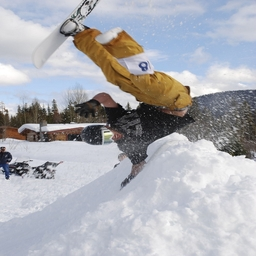

In [5]:
from google.colab.patches import cv2_imshow
import cv2
img = os.listdir('images/train/class')
img = cv2.imread('images/train/class/'+img[27600])
cv2_imshow(img)

In [6]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, transforms

import os, shutil, time

In [7]:

# Check if GPU is available
use_gpu = torch.cuda.is_available()
if use_gpu:
  print("GPU Available.")
else: print("Training on CPU.")

GPU Available.


In [8]:
resnet = models.resnet18() 
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
nn.Sequential(*list(resnet.children())[0:6])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [10]:
class ColorizationUpsampling(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationUpsampling, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## Encoder
    resnet = models.resnet18()
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, x):
    ## Encoder
    x = self.midlevel_resnet(x)
    ## Decoder
    x = self.upsample(x)
    return x

In [11]:

model = ColorizationUpsampling()

In [12]:
# specify loss function
criterion = nn.MSELoss()
# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      gray = rgb2gray(img_original)
      gray = torch.from_numpy(gray).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return gray, img_ab, target

In [14]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [15]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [16]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [17]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: 
      input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [18]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [21]:

# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
#os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 100000
epochs = 100

In [22]:
model.load_state_dict(torch.load('/content/drive/My Drive/colorization_models/checkpoints/model-epoch-27-losses-0.002531.pth' ))

<All keys matched successfully>

In [26]:
# Train model
for epoch in range(30,45):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), '/content/drive/My Drive/colorization_models/checkpoints/model-epoch-{}-losses-{:.6f}.pth'.format(epoch+1,losses))

Starting training epoch 30
Epoch: [30][0/625]	Time 1.414 (1.414)	Data 1.315 (1.315)	Loss 0.0030 (0.0030)	
Epoch: [30][25/625]	Time 1.316 (1.335)	Data 1.240 (1.259)	Loss 0.0024 (0.0029)	
Epoch: [30][50/625]	Time 1.287 (1.324)	Data 1.214 (1.249)	Loss 0.0028 (0.0028)	
Epoch: [30][75/625]	Time 1.318 (1.319)	Data 1.244 (1.245)	Loss 0.0023 (0.0028)	
Epoch: [30][100/625]	Time 1.311 (1.317)	Data 1.237 (1.243)	Loss 0.0026 (0.0027)	
Epoch: [30][125/625]	Time 1.302 (1.315)	Data 1.228 (1.240)	Loss 0.0018 (0.0027)	
Epoch: [30][150/625]	Time 1.340 (1.315)	Data 1.266 (1.240)	Loss 0.0029 (0.0027)	
Epoch: [30][175/625]	Time 1.298 (1.314)	Data 1.224 (1.239)	Loss 0.0025 (0.0027)	
Epoch: [30][200/625]	Time 1.297 (1.312)	Data 1.220 (1.237)	Loss 0.0029 (0.0027)	
Epoch: [30][225/625]	Time 1.285 (1.312)	Data 1.211 (1.237)	Loss 0.0030 (0.0027)	
Epoch: [30][250/625]	Time 1.322 (1.312)	Data 1.247 (1.237)	Loss 0.0021 (0.0027)	
Epoch: [30][275/625]	Time 1.293 (1.310)	Data 1.218 (1.235)	Loss 0.0028 (0.0027)	
Epoch:

<Figure size 432x288 with 0 Axes>

In [29]:
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF
import numpy as np
import torch
from skimage.color import lab2rgb, rgb2gray
#from model import ColorizationUpsampling
import cv2
from google.colab.patches import cv2_imshow


def predict_single():
    """
    Predict and show color image from input image
    :return: None
    """
    path = '/content/drive/My Drive/test/gray/2015_5_24_7_32_47_463.jpg'
    img = Image.open(path)
    img = img.resize((224,224))
    img_original = np.array(img)

    gray = rgb2gray(img_original)
    x = TF.to_tensor(gray).float()
    x.unsqueeze_(0)
    model = ColorizationUpsampling()
    model.load_state_dict(torch.load('/content/drive/My Drive/colorization_models/checkpoints/model-epoch-45-losses-0.002550.pth',
                                     map_location=torch.device('cpu')))

    output = model(x)

    output = output.detach()
    color_image = torch.cat((x[0], output[0]), 0).numpy()
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
    color_image = lab2rgb(color_image.astype(np.float16))

    color_image_bgr = color_image.astype(np.float32)
    color_image_bgr = cv2.cvtColor(color_image_bgr, cv2.COLOR_RGB2BGR)
    color_image_bgr = cv2.resize(color_image_bgr, (380, 240))

    normalized_array = (color_image_bgr - np.min(color_image_bgr)) / (
            np.max(color_image_bgr) - np.min(color_image_bgr))  # this set the range from 0 till 1
    color_image_bgr = (normalized_array * 255).astype(np.uint8)
    gray = cv2.resize(gray, (380, 240))
    gray = np.stack((gray,) * 3, axis=-1)

    gray = (gray - np.min(gray)) / (
            np.max(gray) - np.min(gray))  # this set the range from 0 till 1
    gray = (gray * 255).astype(np.uint8)
    vis = np.concatenate((gray, color_image_bgr), axis=1)

    frame_normed = np.array(vis, np.uint8)

    cv2.imwrite(path[:-4]+"out.jpg", frame_normed)
    cv2_imshow( frame_normed)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

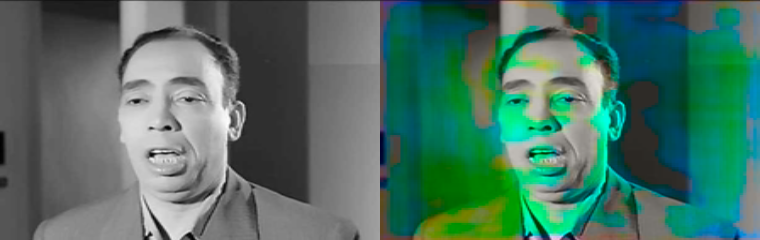

In [30]:
 predict_single()